In [1]:
%load_ext autoreload
%autoreload 2
%aimport

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt 
import re 
from astropy.table import Table
import astropy.table

from relaxed import halo_parameters, halo_catalogs 

Modules to reload:
all-except-skipped

Modules to skip:



In [2]:
plt.rc('text', usetex=True)

In [3]:
%matplotlib inline

# Plot style

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler
plt.style.use('seaborn-colorblind')

In [5]:
mpl.rcParams.update(
{
    # figure
    'figure.figsize':   (10, 10),
    
    # axes
    'axes.labelsize': 24,
    
    # ticks
    'xtick.major.size':  5,
    'xtick.minor.size':  2.5,
    'xtick.major.width': 0.8,
    'xtick.minor.width': 0.6,
    'xtick.labelsize':   20,
    
    'ytick.major.size':  5,
    'ytick.minor.size':  2.5,
    'ytick.major.width': 0.8,
    'ytick.minor.width': 0.6,
    'ytick.labelsize':   20,
    
    #legend
    'legend.fontsize': 24,

})

In [6]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Load catalog

In [7]:
# load catalog we know and love
fpath = Path('/home/imendoza/nbody-relaxed/data/Bolshoi/minh/hlist_1.00035.minh')
name = 'Bolshoi'

# this command just sets up the attributes and filters. Catalog is loaded in the next cell from the *.minh file.
hcat = halo_catalogs.HaloCatalog(name, fpath)

In [8]:
hcat.load_cat_minh()

In [9]:
# Load catalog from minh and apply default filters on-the-fly.  
print('rows in catalog: ', len(hcat.cat))

rows in catalog:  337438


# Add f_sub

In [11]:
from relaxed.subhaloes.catalog import create_subhalo_cat

In [12]:
subhalo_cat = create_subhalo_cat(np.array(hcat.cat['id']), fpath)

In [13]:
# add column to original catalog
assert np.all(subhalo_cat['id'] == hcat.cat['id'])
hcat.cat.add_column(subhalo_cat['f_sub'], name='f_sub')

# Different samples

In [14]:
# All the code necessary to produce plots for the paper will be stored in /figures/code. Note this is not contained inside the main source code directory /relaxed.
# All plots*.py file simply contain functions you can run on a list of HaloCatalogs 'hcats'. 
from matplotlib.backends.backend_pdf import PdfPages

from relaxed.halo_filters import HaloFilter, get_bound_filter, get_relaxed_filters

In [15]:
# use halo_filters to create additional halo_catalogs for analysis. 
hcat_m11 = HaloFilter(get_bound_filter('mvir', high=11.22, modifier=np.log10), 'M11')(hcat)
hcat_m12 = HaloFilter(get_bound_filter('mvir', 12,12.2, modifier=np.log10), 'M12')(hcat)
hcat_m13 = HaloFilter(get_bound_filter('mvir',13,14,modifier=np.log10), 'M13')(hcat)

power_cat = HaloFilter(get_relaxed_filters('power2011'), 'power2011')(hcat)
neto_cat = HaloFilter(get_relaxed_filters('neto2007'), 'neto2007')(hcat)


# for easy of access
dcats = {
    'm11': hcat_m11,
    'm12': hcat_m12,
    'm13': hcat_m13, 
    
    'power': power_cat,
    'neto': neto_cat,    
    'all': hcat,
}
    

In [15]:
# make sure length of catalogs make sense
print(len(hcat))

print(len(hcat_m11), len(hcat_m12), len(hcat_m13))

# 500 haloes are so > 13.75 
print(len(power_cat), len(neto_cat))

337438
56076 19726 5507
213058 263039


# Histograms

In [57]:
def get_bins(values, n_bins=30): 
    return np.histogram(values, bins=n_bins)[1]

def draw_histogram(ax, values, n_bins=30, bins=None, vline='median', legend_label='', color='r'):
    ax.hist(
        values,
        bins=bins if bins is not None else n_bins,
        histtype='step',
        label=legend_label,
        color=color
    )

    # add a vertical line.
    if vline == "median":
        ax.axvline(np.median(values), ls="--", color=color)



## Histogram of Mvir for different samples

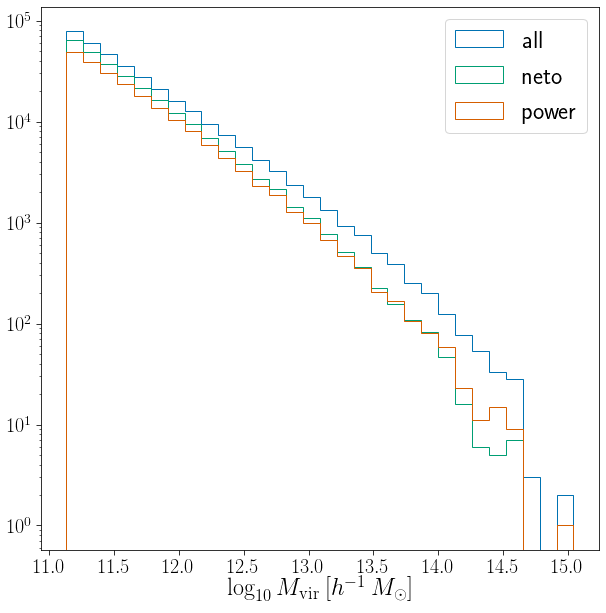

In [58]:
names = ['all', 'neto', 'power']
fig, ax = plt.subplots(1, 1)
n_bins = 30

all_mvirs = np.hstack([np.log10(dcats[name].cat['mvir']) for name in names])
bins = get_bins(all_mvirs, n_bins)


for i, name in enumerate(names):
    c = colors[i]
    legend_label = f'{name}'
    draw_histogram(ax, np.log10(dcats[name].cat['mvir']), bins=bins, color=c, legend_label=name, vline=None)
    
# fix axes and legend.
param_mvir = halo_parameters.get_hparam('mvir', log=True)
ax.set_xlabel(param_mvir.get_text())
plt.yscale('log')
ax.legend()
plt.show()

## Mean-centered and normalized log parameters

In [68]:
# maybe need to do a specific mass bin to have meaningful results here.
def make_mean_centered_histograms(n_bins=30):
    params = ["cvir", "eta", "x0", "v0", "spin", "q", "phi_l"]
    names = ['m11', 'm12', 'm13']
    fig, axes = plt.subplots(2, 4, figsize=(18, 9))
    normalize = lambda x: (x - np.mean(x)) / np.std(x)
    axes = axes.flatten()
    
    for param, ax in zip(params, axes):
        hparam = halo_parameters.get_hparam(param, log=True, modifiers=[normalize])
        label = hparam.get_text()
        all_values = np.hstack([hparam.get_values(dcats[name].cat) for name in names])
        bins = get_bins(all_values, n_bins)
        for c, name in zip(colors, names):
            hcat = dcats[name]
            x = hparam.get_values(hcat.cat)
            draw_histogram(ax, x, bins=bins, vline='median', legend_label=label, color=c)
        ax.set_yscale('log')
    plt.tight_layout()

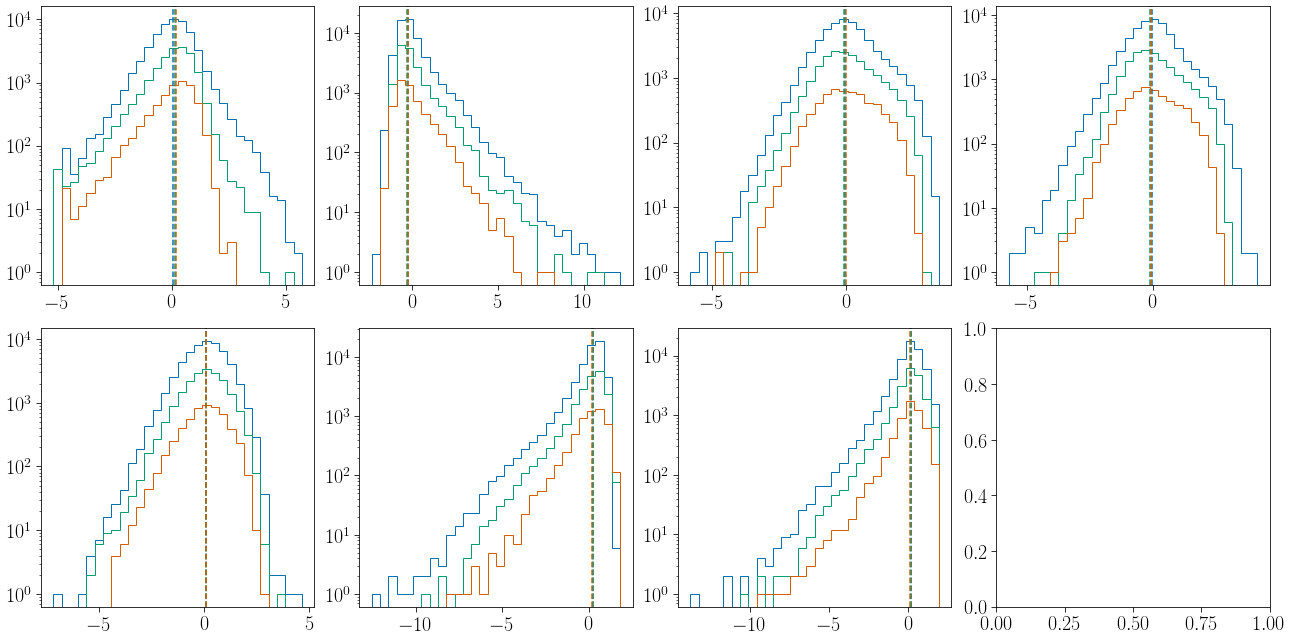

In [69]:
# TODO: add tile -> all haloes for each of the samples, add legend to the first plot, add xlabel
make_mean_centered_histograms()

# Scatter binning

## Relaxed parameters as a function of mass bin

## Histograms 

## Plots comparing all the catalog vs relaxed catalogs

In [ ]:
out='test1.pdf'
hcats = [hcat, power_cat, neto_cat]
pdf_path = utils.figure_path.joinpath(out)
with PdfPages(pdf_path) as pdf:
    plots1.plot_mvir_histogram(hcats, pdf)
    plots1.plot_scatter_relaxed_and_mass(hcats, pdf)


## Plots comparing mass binned (decades) versions of catalog

In [ ]:
out='test2.pdf'
hcats = [hcat_m11, hcat_m12, hcat_m13]
pdf_path = '/home/imendoza/nbody-relaxed/figures/matrix2.pdf'
with PdfPages(pdf_path) as pdf:
#     plots1.plot_correlation_matrix_basic(hcats, pdf=pdf)
#     plots1.plot_mean_centered_hists(hcats, pdf)
    plots1.plot_pair_relaxed_correlation(hcats, pdf)